<a href="https://colab.research.google.com/github/Lou1108/DeepLearning/blob/main/Assignment2/Simplified_layers_meg_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


What we need to do
*   do the pre processing seperately and save the data
*   check and try different models to see if there's one working better with the data
* grid search on the number of the neurons in the layers



### Assignment 2

# Imports and Variables


In [86]:
import os
import glob
import h5py
import numpy as np
from collections import Counter

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt, decimate

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import MultiHeadAttention, Reshape, Permute
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input,

    Conv1D,
    Conv2D,

    DepthwiseConv2D,
    SeparableConv2D,

    MaxPooling1D,

    GlobalAveragePooling1D,
    AveragePooling2D,

    LSTM,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Activation,
    Lambda,
    concatenate
)


In [3]:
TRAIN_PATH = "/content/drive/MyDrive/Deep Learning/Final Project data/Intra/train"
TEST_PATH = "/content/drive/MyDrive/Deep Learning/Final Project data/Intra/test"

# data specific
NUM_CHANNELS = 248
NUM_CLASSES = 4
LABEL_MAP = {'rest':0, 'task_motor':1, 'task_story_math':2, 'task_working_memory':3}
NUM_CLASSES = len(LABEL_MAP)
orig_fs=2034
target_fs=250
DOWNSAMPLE_FACTOR =  int(orig_fs / target_fs)

# Model specific
NUM_EPOCHS = 1
NORMALIZATION_METHOD = "time"  # Choose: "minmax", "zscore", or "perchannel"

In [4]:
def load_data(file_paths):
    data = []
    labels = []
    for file_path in file_paths:
        # Extractin the label
        filename = file_path.split('/')[-1]

        #handling the different task naming conventions
        if 'rest' in filename:
            labels.append(LABEL_MAP['rest'])
        elif 'motor' in filename:
            labels.append(LABEL_MAP['task_motor'])
        elif 'story' in filename or 'math' in filename:
             labels.append(LABEL_MAP['task_story_math'])
        elif 'working' in filename or 'memory' in filename:
            labels.append(LABEL_MAP['task_working_memory'])
        else:
            # iff a file doesn't match
            print(f"Could not determine task for file: {filename}")
            continue

        with h5py.File(file_path, 'r') as f:
            # Instead of guessing the dataset name, we get the first key from the file
            # This is robust because we know there is only one dataset per file[cite: 10].
            dataset_name = list(f.keys())[0]
            matrix = f[dataset_name][()]
            data.append(matrix)

    #convert to numpy arrays
    return np.array(data), np.array(labels)

In [5]:
train_files = glob.glob(f"{TRAIN_PATH}/*.h5")
test_files = glob.glob(f"{TEST_PATH}/*.h5")

X_train, y_train = load_data(train_files)
X_test, y_test = load_data(test_files)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Uniqe labels: {np.unique(y_train)}")
print(f"Number of training samples: {len(X_train)}")

Shape of X_train: (32, 248, 35624)
Shape of y_train: (32,)
Shape of X_test: (8, 248, 35624)
Uniqe labels: [0 1 2 3]
Number of training samples: 32


# Load and Preprocess Data
Apply a lowpass filter for downsampling the frequency

In [6]:
# lowpass filter ---> check it
# def bandpass_filter(data, lowcut=1.0, highcut=150.0, fs=2034, order=5):
#     nyq = 0.5 * fs
#     low = lowcut / nyq
#     high = highcut / nyq
#     b, a = butter(order, [low, high], btype='band')
#     return filtfilt(b, a, data, axis=-1)

Normalization functions

In [7]:
def min_max_scale_sample(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data.reshape(-1, 1)).reshape(data.shape)

def z_score_normalize(data):
    mean = data.mean(axis=-1, keepdims=True)
    std = data.std(axis=-1, keepdims=True)
    return (data - mean) / (std + 1e-8)

def time_norm(data):
    n_samples, n_channels, n_timesteps = data.shape
    reshaped_data = data.reshape(n_samples * n_channels, n_timesteps)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(reshaped_data)

    # Reshape back to the original shape
    return scaled_data.reshape(n_samples, n_channels, n_timesteps)

In [8]:
def normalization(data):
    if NORMALIZATION_METHOD == "minmax":
        data = min_max_scale_sample(data)
    elif NORMALIZATION_METHOD == "zscore":
        data = z_score_normalize(data)
    elif NORMALIZATION_METHOD == "time":
        data = time_norm(data)
    return data

In [9]:
def normalize_data(data):
    # Data shape is (n_samples, n_channels, n_timesteps)
    # We want to scale each of the (n_samples * n_channels) time series

    # Reshape to (n_samples * n_channels, n_timesteps) to apply StandardScaler
    n_samples, n_channels, n_timesteps = data.shape
    reshaped_data = data.reshape(n_samples * n_channels, n_timesteps)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(reshaped_data)

    # Reshape back to the original shape
    return scaled_data.reshape(n_samples, n_channels, n_timesteps)

In [10]:
X_train.shape

(32, 248, 35624)

In [11]:
N_TIMESTEPS = X_train.shape[2]
X_train_ds=decimate(X_train, DOWNSAMPLE_FACTOR, axis=-1, ftype='fir', zero_phase=True)
X_test_ds=decimate(X_test, DOWNSAMPLE_FACTOR, axis=-1, ftype='fir', zero_phase=True)
X_train_ds = X_train[:, :, ::DOWNSAMPLE_FACTOR]
X_test_ds = X_test[:, :, ::DOWNSAMPLE_FACTOR]

N_TIMESTEPS_DS = X_train_ds.shape[2]

print(f"Original number of time steps: {N_TIMESTEPS}")
print(f"Downsampled number of time steps: {N_TIMESTEPS_DS}")

Original number of time steps: 35624
Downsampled number of time steps: 4453


In [12]:
X_train_norm = normalization(X_train_ds)
X_test_norm = normalization(X_test_ds)

In [13]:
#DL models in Keras often expect the channel dimension last
#reshaping from (samples, channels, timesteps) to (samples, timesteps, channels)
X_train_final = np.transpose(X_train_norm, (0, 2, 1))
X_test_final = np.transpose(X_test_norm, (0, 2, 1))

print(f"Final shape of training data for the model: {X_train_final.shape}")

Final shape of training data for the model: (32, 4453, 248)


In [14]:
callbacks = [
    EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True)
]

# Define Models

###CNN model
good for local temporal patterns

In [15]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(16, 3, padding='same', activation='elu',
               kernel_regularizer=regularizers.l2(1e-2)),
        BatchNormalization(),
        GlobalAveragePooling1D(),
        Dropout(0.6),
        Dense(num_classes, activation='softmax')
    ])


    return model

In [16]:
INPUT_SHAPE = (N_TIMESTEPS_DS, NUM_CHANNELS)

cnn_model = build_cnn_model(INPUT_SHAPE, NUM_CLASSES)
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Use sparse CE because our labels are integers
    metrics=['accuracy']
)
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4453, 16)       │        11,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4453, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,052 (47.08 KB)

 Trainable params: 12,020 (46.95 KB)

 Non-trainable params: 32 (128.00 B)

Training and evaluation of CNN

In [17]:
history_cnn = cnn_model.fit(
    X_train_final,
    y_train,
    epochs=20,
    batch_size=16,      # smaller batch size for better generalization
    validation_split=0.2, # 20% of training data for validation
    callbacks=callbacks
)

# Evaluate on test Sets
loss_cnn, acc_cnn = cnn_model.evaluate(X_test_final, y_test, verbose=0)
print(f"accuracy on test set: {acc_cnn * 100:.2f}%")

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step - accuracy: 0.3708 - loss: 1.9710 - val_accuracy: 0.5714 - val_loss: 1.2252
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5817 - loss: 1.1478 - val_accuracy: 0.5714 - val_loss: 1.1043
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6825 - loss: 1.0632 - val_accuracy: 0.5714 - val_loss: 1.0104
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8250 - loss: 0.8478 - val_accuracy: 0.7143 - val_loss: 0.9307
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8783 - loss: 0.7339 - val_accuracy: 1.0000 - val_loss: 0.8690
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8783 - loss: 0.7784 - val_accuracy: 1.0000 - val_loss: 0.8152
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9258 - loss: 0.6477 - val_accuracy: 1.0000 - val_loss: 0.7679
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8517 - loss: 0.7291 - val_accuracy: 1.0000 - val_loss:

## Training and evaluation LSTM Model
Adds memory to model long-range dependencies.

In [18]:
def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        # 1 conv block
        Conv1D(filters=32, kernel_size=5, padding='same', activation='elu', kernel_regularizer=regularizers.l2(1e-3)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Lstm
        LSTM(units=32, return_sequences=False, kernel_regularizer=regularizers.l2(1e-3)),

        # Dense head
        Dense(32,activation='elu',kernel_regularizer=regularizers.l2(1e-3)),
        Dropout(0.5),
        # Softmax
        Dense(num_classes, activation='softmax')
    ])

    return model


In [19]:
INPUT_SHAPE = (N_TIMESTEPS_DS, NUM_CHANNELS)

cnn_lstm_model = build_cnn_lstm_model(INPUT_SHAPE, NUM_CLASSES)

cnn_lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 4453, 32)       │        39,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4453, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2226, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,348 (192.77 KB)

 Trainable params: 49,284 (192.52 KB)

 Non-trainable params: 64 (256.00 B)

In [20]:
#CNN-LSTM Training and Evaluation
print("Starting CNN-LSTM model training...")
history_cnn_lstm = cnn_lstm_model.fit(
    X_train_final,
    y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=callbacks
)

# Evaluate on test sets
loss_hybrid, acc_hybrid = cnn_lstm_model.evaluate(X_test_final, y_test, verbose=0)
print(f"Hybrid Model Accuracy on Test Set: {acc_hybrid * 100:.2f}%")

Starting CNN-LSTM model training...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2283 - loss: 1.7886 - val_accuracy: 0.1429 - val_loss: 1.6751
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4925 - loss: 1.2573 - val_accuracy: 0.2857 - val_loss: 1.3366
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7358 - loss: 0.9323 - val_accuracy: 0.7143 - val_loss: 1.1850
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9525 - loss: 0.8443 - val_accuracy: 0.8571 - val_loss: 1.0640
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9050 - loss: 0.7518 - val_accuracy: 1.0000 - val_loss: 0.9463
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9733 - loss: 0.6691 - val_accuracy: 1.0000 - val_loss: 0.8487
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9525 - loss: 0.6245 - val_accuracy: 1.0000 - val_loss: 0.7767
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 1.0000 - loss: 0.6314 - val_accuracy: 1.0000

## Training EEGNet model
Designed for EEG-like signals, uses depthwise separable convolutions to reduce parameters.

In [21]:
def build_eegnet_model(num_classes, channels, timesteps, dropout_rate=0.5):
    input_layer = Input(shape=(channels, timesteps, 1))

    # temporal convolution
    block1 = Conv2D(16, (1, 64), padding='same', use_bias=False)(input_layer)
    block1 = BatchNormalization()(block1)

    #Depthwise spatial convolution
    block1 = DepthwiseConv2D((channels, 1), use_bias=False, depth_multiplier=2, depthwise_constraint=tf.keras.constraints.max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropout_rate)(block1)

    # separable convolution
    block2 = SeparableConv2D(32, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropout_rate)(block2)

    # classification head
    flatten_layer = Flatten()(block2)
    dense_layer = Dense(num_classes, kernel_constraint=tf.keras.constraints.max_norm(0.25))(flatten_layer)
    output_layer = Activation('softmax')(dense_layer)

    return Model(inputs=input_layer, outputs=output_layer)

In [22]:
# Reshape data
X_train_eegnet = X_train_norm[..., np.newaxis]
X_test_eegnet = X_test_norm[..., np.newaxis]
print(f"Shape of data for EEGNet: {X_train_eegnet.shape}")

eegnet_model = build_eegnet_model(
    num_classes=NUM_CLASSES,
    channels=NUM_CHANNELS,
    timesteps=N_TIMESTEPS_DS
)

eegnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

eegnet_model.summary()

# Define the earlystopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Shape of data for EEGNet: (32, 248, 4453, 1)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 248, 4453, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 248, 4453, 16)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 248, 4453, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 1, 4453, 32)    │         7,936 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 4453, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 4453, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1113, 32)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1113, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 1113, 32)    │         1,536 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 1113, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 1113, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 139, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 139, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4448)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │        17,796 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,612 (111.77 KB)

 Trainable params: 28,452 (111.14 KB)

 Non-trainable params: 160 (640.00 B)

In [23]:
history_eegnet = eegnet_model.fit(
    X_train_eegnet,
    y_train,
    epochs=20,  # We can still set a high number, but early stopping will likely stop it earlier
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping]
)

print("\nEvaluating EEGNet model on test sets")

loss_eegnet, acc_eegnet = eegnet_model.evaluate(X_test_eegnet, y_test, verbose=0)
print(f"EEGNet Model Accuracy on Test Set 1: {acc_eegnet * 100:.2f}%")

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 12s/step - accuracy: 0.6883 - loss: 1.0233 - val_accuracy: 0.5714 - val_loss: 1.3064
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 12s/step - accuracy: 0.7833 - loss: 0.5241 - val_accuracy: 0.5714 - val_loss: 1.2047
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 12s/step - accuracy: 0.8308 - loss: 0.3082 - val_accuracy: 1.0000 - val_loss: 1.1348
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 12s/step - accuracy: 0.9733 - loss: 0.1184 - val_accuracy: 1.0000 - val_loss: 1.0781
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 12s/step - accuracy: 0.9733 - loss: 0.0561 - val_accuracy: 1.0000 - val_loss: 1.0325
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 12s/step - accuracy: 0.9733 - loss: 0.0725 - val_accuracy: 1.0000 - val_loss: 1.0034
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 11s/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.8571 - val_loss: 0.9845
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 12s/step - accuracy: 0.9733 - loss: 0.0366 - val_accuracy: 0.8571 - val_loss: 0.9548


Now I wanna try to use the same models for the cross subject and see if, even if very simple, they still work well with a satisfying accuracy.

In [24]:
BASE_PATH = '/content/drive/MyDrive/Deep Learning/Final Project data/Cross'

TRAIN_DIR = os.path.join(BASE_PATH, 'train/')
TEST1_DIR = os.path.join(BASE_PATH, 'test1/')
TEST2_DIR = os.path.join(BASE_PATH, 'test2/')
TEST3_DIR = os.path.join(BASE_PATH, 'test3/')

# Each file has 248 sensor readings (rows) and 35624 time steps (columns)
N_CHANNELS = 248
N_TIMESTEPS = 35624

# The 4 states we want to classify
TASKS = ['rest', 'task_motor', 'task_story_math', 'task_working_memory']
# Map tasks to integer labels
task_to_label = {task: i for i, task in enumerate(TASKS)}

In [25]:
# Function to load data from a list of file paths
def load_data(file_paths):
    data = []
    labels = []
    for file_path in file_paths:
        # Extractin the label
        filename = file_path.split('/')[-1]

        #handling the different task naming conventions
        if 'rest' in filename:
            labels.append(task_to_label['rest'])
        elif 'motor' in filename:
            labels.append(task_to_label['task_motor'])
        elif 'story' in filename or 'math' in filename:
             labels.append(task_to_label['task_story_math'])
        elif 'working' in filename or 'memory' in filename:
            labels.append(task_to_label['task_working_memory'])
        else:
            # iff a file doesn't match
            print(f"Could not determine task for file: {filename}")
            continue

        with h5py.File(file_path, 'r') as f:
            # Instead of guessing the dataset name, we get the first key from the file
            # This is robust because we know there is only one dataset per file[cite: 10].
            dataset_name = list(f.keys())[0]
            matrix = f[dataset_name][()]
            data.append(matrix)

    #convert to numpy arrays
    return np.array(data), np.array(labels)

In [26]:
train_files = glob.glob(f"{TRAIN_DIR}/*.h5")
test1_files = glob.glob(f"{TEST1_DIR}/*.h5")
test2_files = glob.glob(f"{TEST2_DIR}/*.h5")
test3_files = glob.glob(f"{TEST3_DIR}/*.h5")

X_train, y_train = load_data(train_files)
X_test1, y_test1 = load_data(test1_files)
X_test2, y_test2 = load_data(test2_files)
X_test3, y_test3 = load_data(test3_files)


print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test1: {X_test1.shape}")
print(f"Uniqe labels: {np.unique(y_train)}")
print(f"Number of training samples: {len(X_train)}")

Shape of X_train: (64, 248, 35624)
Shape of y_train: (64,)
Shape of X_test1: (16, 248, 35624)
Uniqe labels: [0 1 2 3]
Number of training samples: 64


In [27]:
# --- Downsampling ---
# The original sample rate is 2034Hz
#take every 10th sample
DOWNSAMPLE_FACTOR = 10
X_train_ds = X_train[:, :, ::DOWNSAMPLE_FACTOR]
X_test1_ds = X_test1[:, :, ::DOWNSAMPLE_FACTOR]
X_test2_ds = X_test2[:, :, ::DOWNSAMPLE_FACTOR]
X_test3_ds = X_test3[:, :, ::DOWNSAMPLE_FACTOR]

N_TIMESTEPS_DS = X_train_ds.shape[2]
print(f"Original number of time steps: {N_TIMESTEPS}")
print(f"Downsampled number of time steps: {N_TIMESTEPS_DS}")

print("\nNormalizing data...")
X_train_norm = normalize_data(X_train_ds)
X_test1_norm = normalize_data(X_test1_ds)
X_test2_norm = normalize_data(X_test2_ds)
X_test3_norm = normalize_data(X_test3_ds)

print("Normalization complete.")

#DL models in Keras often expect the channel dimension last
#reshaping from (samples, channels, timesteps) to (samples, timesteps, channels)
X_train_final = np.transpose(X_train_norm, (0, 2, 1))
X_test1_final = np.transpose(X_test1_norm, (0, 2, 1))
X_test2_final = np.transpose(X_test2_norm, (0, 2, 1))
X_test3_final = np.transpose(X_test3_norm, (0, 2, 1))

print(f"Final shape of training data for the model: {X_train_final.shape}")

Original number of time steps: 35624
Downsampled number of time steps: 3563

Normalizing data...
Normalization complete.
Final shape of training data for the model: (64, 3563, 248)


Data analysis of test 2

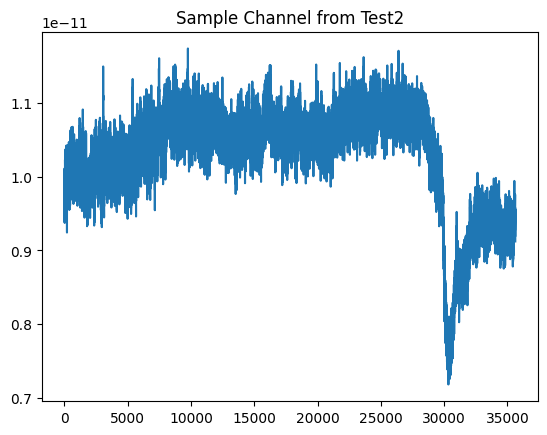

In [28]:
import matplotlib.pyplot as plt

with h5py.File("/content/drive/MyDrive/Deep Learning/Final Project data/Cross/test2/rest_707749_10.h5", 'r') as f:
    data = f[list(f.keys())[0]][()]
    plt.plot(data[0])  # First channel as example
    plt.title("Sample Channel from Test2")
    plt.show()

<Axes: xlabel='PC1', ylabel='PC2'>

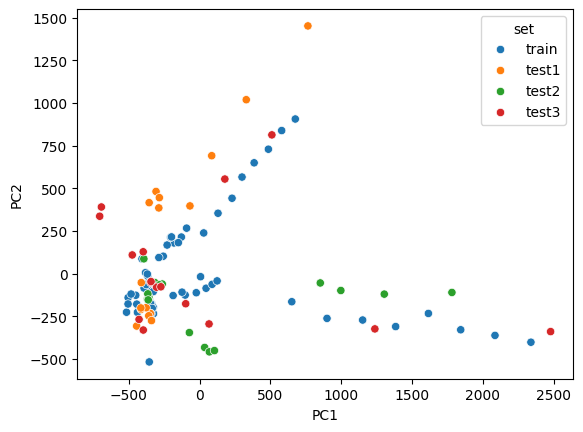

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_all = np.concatenate([X_train_final, X_test1_final, X_test2_final, X_test3_final])
X_all = X_all.reshape(X_all.shape[0], -1)  # flatten

pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X_all))

# Visualize by dataset
import seaborn as sns
import pandas as pd

labels = (['train'] * X_train_final.shape[0] +
          ['test1'] * X_test1_final.shape[0] +
          ['test2'] * X_test2_final.shape[0] +
          ['test3'] * X_test3_final.shape[0])

df = pd.DataFrame({'PC1': X_pca[:, 0], 'PC2': X_pca[:, 1], 'set': labels})
sns.scatterplot(data=df, x='PC1', y='PC2', hue='set')

CNN

In [30]:
INPUT_SHAPE = (N_TIMESTEPS_DS, N_CHANNELS)
NUM_CLASSES = len(TASKS)

cnn_model = build_cnn_model(INPUT_SHAPE, NUM_CLASSES)
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Use sparse CE because our labels are integers
    metrics=['accuracy']
)
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 3563, 16)       │        11,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3563, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,052 (47.08 KB)

 Trainable params: 12,020 (46.95 KB)

 Non-trainable params: 32 (128.00 B)

In [31]:
history_cnn = cnn_model.fit(
    X_train_final,
    y_train,
    epochs=20,
    batch_size=16,      # smaller batch size for better generalization
    validation_split=0.2 # 20% of training data for validation
)

# Evaluate on test Sets
loss1_cnn, acc1_cnn = cnn_model.evaluate(X_test1_final, y_test1, verbose=0)
print(f"accuracy on test set 1: {acc1_cnn * 100:.2f}%")
loss2_cnn, acc2_cnn = cnn_model.evaluate(X_test2_final, y_test2, verbose=0)
print(f"accuracy on test set 2: {acc2_cnn * 100:.2f}%")
loss3_cnn, acc3_cnn = cnn_model.evaluate(X_test3_final, y_test3, verbose=0)
print(f"accuracy on test set 3: {acc3_cnn * 100:.2f}%")

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.4841 - loss: 1.8559 - val_accuracy: 0.4615 - val_loss: 1.4216
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6854 - loss: 1.0650 - val_accuracy: 0.4615 - val_loss: 1.2492
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6417 - loss: 1.1317 - val_accuracy: 0.6923 - val_loss: 1.1232
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7074 - loss: 0.9389 - val_accuracy: 0.7692 - val_loss: 1.0283
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7714 - loss: 0.9183 - val_accuracy: 0.7692 - val_loss: 0.9558
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8237 - loss: 0.7608 - val_accuracy: 0.7692 - val_loss: 0.8872
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7469 - loss: 0.8506 - val_accuracy: 0.7692 - val_loss: 0.8389
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8847 - loss: 0.6735 - val_accuracy: 0.7692 - val_loss: 0.8080

## LSTM

For this model we have that the accuracy of the second teste set is very low. The model may be overfitting to the subjects in the training set, learning subject-specific features.
When it encounters Test Set 2, which may contain a subject whose MEG patterns deviate more significantly, generalization fails.



In [32]:
cnn_lstm_model = build_cnn_lstm_model(INPUT_SHAPE, NUM_CLASSES)

cnn_lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 3563, 32)       │        39,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 3563, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1781, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,348 (192.77 KB)

 Trainable params: 49,284 (192.52 KB)

 Non-trainable params: 64 (256.00 B)

In [33]:
print("Starting CNN-LSTM model training...")
history_cnn_lstm = cnn_lstm_model.fit(
    X_train_final,
    y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.2
)

# Evaluate on test sets
loss1_hybrid, acc1_hybrid = cnn_lstm_model.evaluate(X_test1_final, y_test1, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 1: {acc1_hybrid * 100:.2f}%")
loss2_hybrid, acc2_hybrid = cnn_lstm_model.evaluate(X_test2_final, y_test2, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 2: {acc2_hybrid * 100:.2f}%")
loss3_hybrid, acc3_hybrid = cnn_lstm_model.evaluate(X_test3_final, y_test3, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 3: {acc3_hybrid * 100:.2f}%")

Starting CNN-LSTM model training...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 994ms/step - accuracy: 0.4575 - loss: 1.4345 - val_accuracy: 0.6154 - val_loss: 1.2125
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 875ms/step - accuracy: 0.6364 - loss: 1.1705 - val_accuracy: 0.6923 - val_loss: 1.1137
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 927ms/step - accuracy: 0.7371 - loss: 0.9694 - val_accuracy: 0.7692 - val_loss: 1.0248
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 891ms/step - accuracy: 0.8387 - loss: 0.9207 - val_accuracy: 0.7692 - val_loss: 0.9212
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 839ms/step - accuracy: 0.7846 - loss: 0.8235 - val_accuracy: 0.8462 - val_loss: 0.8444
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 865ms/step - accuracy: 0.9436 - loss: 0.6780 - val_accuracy: 0.8462 - val_loss: 0.7801
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 907ms/step - accuracy: 0.9431 - loss: 0.6103 - val_accuracy: 0.9231 - val_loss: 0.7113
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 897ms/step - accuracy: 0.9332 - loss: 0.548

EEGNet

https://arxiv.org/pdf/1611.08024

In [34]:
# Reshape data
X_train_eegnet = X_train_norm[..., np.newaxis]
X_test1_eegnet = X_test1_norm[..., np.newaxis]
X_test2_eegnet = X_test2_norm[..., np.newaxis]
X_test3_eegnet = X_test3_norm[..., np.newaxis]

print(f"Shape of data for EEGNet: {X_train_eegnet.shape}")

eegnet_model = build_eegnet_model(
    num_classes=NUM_CLASSES,
    channels=N_CHANNELS,
    timesteps=N_TIMESTEPS_DS
)

eegnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

eegnet_model.summary()

# Define the earlystopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Shape of data for EEGNet: (64, 248, 3563, 1)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 248, 3563, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 248, 3563, 16)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 248, 3563, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 1, 3563, 32)    │         7,936 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 3563, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1, 3563, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 1, 890, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 890, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 1, 890, 32)     │         1,536 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1, 890, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1, 890, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 1, 111, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3552)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │        14,212 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,028 (97.77 KB)

 Trainable params: 24,868 (97.14 KB)

 Non-trainable params: 160 (640.00 B)

In [35]:
print("\nStarting EEGNet model training with Early Stopping...")
history_eegnet = eegnet_model.fit(
    X_train_eegnet,
    y_train,
    epochs=50,  # We can still set a high number, but early stopping will likely stop it earlier
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping]
)

print("\nEvaluating EEGNet model on test sets")
loss1_eegnet, acc1_eegnet = eegnet_model.evaluate(X_test1_eegnet, y_test1, verbose=0)
print(f"EEGNet Model Accuracy on Test Set 1: {acc1_eegnet * 100:.2f}%")

loss2_eegnet, acc2_eegnet = eegnet_model.evaluate(X_test2_eegnet, y_test2, verbose=0)
print(f"EEGNet Model Accuracy on Test Set 2: {acc2_eegnet * 100:.2f}%")

loss3_eegnet, acc3_eegnet = eegnet_model.evaluate(X_test3_eegnet, y_test3, verbose=0)
print(f"EEGNet Model Accuracy on Test Set 3: {acc3_eegnet * 100:.2f}%")


Starting EEGNet model training with Early Stopping...
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 10s/step - accuracy: 0.3131 - loss: 1.7879 - val_accuracy: 0.3077 - val_loss: 1.3182
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 48s 11s/step - accuracy: 0.7522 - loss: 0.6924 - val_accuracy: 0.3077 - val_loss: 1.2407
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 11s/step - accuracy: 0.9025 - loss: 0.4073 - val_accuracy: 0.6923 - val_loss: 1.1795
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 11s/step - accuracy: 0.8768 - loss: 0.2878 - val_accuracy: 0.6923 - val_loss: 1.1266
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 10s/step - accuracy: 0.9358 - loss: 0.2460 - val_accuracy: 0.7692 - val_loss: 1.0868
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 11s/step - accuracy: 0.8456 - loss: 0.3403 - val_accuracy: 0.8462 - val_loss: 1.0675
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 12s/step - accuracy: 0.8602 - loss: 0.2511 - val_accuracy: 1.0000 - val_loss: 1.0657
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 11s/step - accuracy: 0.9202 - 

We can introduce attention in order to see if there's an improvement on the overall accuracy increasing the generalization and in particular if it avoids the lack of good ac. on test 2

In [82]:
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, BatchNormalization, Activation,
    AveragePooling2D, Dropout, SeparableConv2D, Flatten, Dense,
    MultiHeadAttention, LayerNormalization, Reshape, Permute
)
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import max_norm

def build_eegnet_temporal_attention(num_classes, channels, timesteps, dropout_rate=0.5, num_heads=4, key_dim=16):
    input_layer = Input(shape=(channels, timesteps, 1))

    # Temporal convolution
    x = Conv2D(16, (1, 64), padding='same', use_bias=False)(input_layer)
    x = BatchNormalization()(x)

    # Spatial depthwise convolution
    x = DepthwiseConv2D((channels, 1), use_bias=False, depth_multiplier=2,
                        depthwise_constraint=max_norm(1.))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropout_rate)(x)

    # Separable conv block
    x = SeparableConv2D(32, (1, 16), use_bias=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 8))(x)
    x = Dropout(dropout_rate)(x)

    # -----------------------------
    # Temporal Attention Block
    # -----------------------------
    # Reshape for temporal attention:
    # From (batch, channels, time, features) → (batch, time, features)
    x = Permute((2, 1, 3))(x)                 # (batch, time, channels, features)
    t_steps = x.shape[1]
    x = Reshape((t_steps, -1))(x)             # (batch, time, channels × features)

    # Multi-head attention across time
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = LayerNormalization()(x + attn_out)    # Residual connection + norm

    # -----------------------------
    # Classification head
    # -----------------------------
    x = Flatten()(x)
    x = Dense(num_classes, kernel_constraint=max_norm(0.25))(x)
    output_layer = Activation('softmax')(x)

    return Model(inputs=input_layer, outputs=output_layer)

In [75]:
X_train_eegnet.shape

(64, 248, 3563, 1)

In [83]:
model_att = build_eegnet_temporal_attention(
    num_classes=NUM_CLASSES,
    channels=248,
    timesteps=3563
)

model_att.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_att.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 248, 3563, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 248, 3563, │      1,024 │ input_layer_20[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 248, 3563, │         64 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_6  │ (None, 1, 3563,   │      7,936 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 3563,   │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 1, 3563,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 1, 890,    │          0 │ activation_16[0]… │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 1, 890,    │          0 │ average_pooling2… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_5  │ (None, 1, 890,    │      1,536 │ dropout_20[0][0]  │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 890,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 1, 890,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 1, 111,    │          0 │ activation_17[0]… │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 1, 111,    │          0 │ average_pooling2… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 111, 1,    │          0 │ dropout_21[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 111, 32)   │          0 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 111, 32)   │      8,416 │ reshape_6[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 111, 32)   │          0 │ reshape_6[0][0],  │
│                     │                   │            │ multi_head_atten

 Total params: 33,508 (130.89 KB)

 Trainable params: 33,348 (130.27 KB)

 Non-trainable params: 160 (640.00 B)

In [84]:
print("\nStarting EEGNet model training with Early Stopping and self attention...")
history_att_eegnet = model_att.fit(
    X_train_eegnet,
    y_train,
    epochs=20,  # We can still set a high number, but early stopping will likely stop it earlier
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping]
)
print("\nEvaluating EEGNet model on test sets")
loss1_eegnet, acc1_eegnet = model_att.evaluate(X_test1_eegnet, y_test1, verbose=0)
print(f"EEGNet Model Accuracy on Test Set 1: {acc1_eegnet * 100:.2f}%")

loss2_eegnet, acc2_eegnet = model_att.evaluate(X_test2_eegnet, y_test2, verbose=0)
print(f"EEGNet Model Accuracy on Test Set 2: {acc2_eegnet * 100:.2f}%")

loss3_eegnet, acc3_eegnet = model_att.evaluate(X_test3_eegnet, y_test3, verbose=0)
print(f"EEGNet Model Accuracy on Test Set 3: {acc3_eegnet * 100:.2f}%")


Starting EEGNet model training with Early Stopping and self attention...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 53s 11s/step - accuracy: 0.5864 - loss: 1.2061 - val_accuracy: 0.6923 - val_loss: 0.7940
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 11s/step - accuracy: 0.8581 - loss: 0.4115 - val_accuracy: 0.5385 - val_loss: 0.9231
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 11s/step - accuracy: 0.8763 - loss: 0.2804 - val_accuracy: 0.5385 - val_loss: 1.1161
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 11s/step - accuracy: 0.8555 - loss: 0.2405 - val_accuracy: 0.6154 - val_loss: 0.9549
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 11s/step - accuracy: 0.9614 - loss: 0.1554 - val_accuracy: 0.7692 - val_loss: 0.7415
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 11s/step - accuracy: 0.9556 - loss: 0.2473 - val_accuracy: 0.8462 - val_loss: 0.7146
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 11s/step - accuracy: 0.8597 - loss: 0.3382 - val_accuracy: 0.8462 - val_loss: 0.4888
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 11s/step - 

In [85]:
def build_cascadeNet_model(num_classes, channels, timesteps, dropout_rate=0.5, window_size=1):
    inputs = []
    convs = []
    for i in range(window_size):
        input_layer = Input(shape=(channels, timesteps, 1), name = "input"+str(i+1))
        inputs.append(input_layer)

    for i in range(window_size):
        conv1 = Conv2D(1, (1, 64), padding='same', name = str(i+1)+"conv"+str(1))(inputs[i])
        conv2 = Conv2D(2, (1, 64), padding='same',name = str(i+1)+"conv"+str(2))(conv1)
        conv3 = Conv2D(4, (1, 64), padding='same', name = str(i+1)+"conv"+str(3))(conv2)

        flat = Flatten(name = str(i+1)+"flatten")(conv3)
        dense = Dense(125, activation = "relu",name = str(i+1)+"dense")(flat)
        dense2 = Dropout(dropout_rate,name = str(i+1)+"dropout")(dense)

        dense2 = Lambda(lambda X: tf.expand_dims(X, axis=1))(dense2)
        convs.append(dense2)

    merge = concatenate(convs,axis=1,name = "merge")
    lstm1 = LSTM(10, return_sequences=True,name = "lstm1")(merge)
    lstm2 = LSTM(10, return_sequences=False,name = "lstm2")(lstm1)
    dense3 = Dense(125, activation="relu",name = "dense2")(lstm2)
    final = Dropout(dropout_rate, name = "dropout1")(dense3)
    output = Dense(num_classes, activation="softmax",name = "dense3")(final)

    model = Model(inputs=inputs, outputs=output)
    return model

In [87]:
# Reshape data
X_train_casc = X_train_norm[..., np.newaxis]
X_test_casc = X_test_norm[..., np.newaxis]
print(f"Shape of data for EEGNet: {X_train_casc.shape}")

casc_model = build_cascadeNet_model(
    num_classes=NUM_CLASSES,
    channels=NUM_CHANNELS,
    timesteps=N_TIMESTEPS_DS
)

casc_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

casc_model.summary()

# Define the earlystopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Shape of data for EEGNet: (64, 248, 3563, 1)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input1 (InputLayer)             │ (None, 248, 3563, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1conv1 (Conv2D)                 │ (None, 248, 3563, 1)   │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1conv2 (Conv2D)                 │ (None, 248, 3563, 2)   │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1conv3 (Conv2D)                 │ (None, 248, 3563, 4)   │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1flatten (Flatten)              │ (None, 3534496)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1dense (Dense)                  │ (None, 125)            │   441,812,125 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1dropout (Dropout)              │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1, 125)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ merge (Concatenate)             │ (None, 1, 125)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (LSTM)                    │ (None, 1, 10)          │         5,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (LSTM)                    │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 125)            │         1,375 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 4)              │           504 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 441,820,995 (1.65 GB)

 Trainable params: 441,820,995 (1.65 GB)

 Non-trainable params: 0 (0.00 B)

In [91]:
history_casc = casc_model.fit(
    X_train_casc,
    y_train,
    epochs=10,  # We can still set a high number, but early stopping will likely stop it earlier
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 60s 14s/step - accuracy: 0.3798 - loss: 1.3589 - val_accuracy: 0.5385 - val_loss: 1.3477
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 58s 13s/step - accuracy: 0.3444 - loss: 1.3687 - val_accuracy: 0.4615 - val_loss: 1.3592
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 59s 14s/step - accuracy: 0.3844 - loss: 1.3539 - val_accuracy: 0.4615 - val_loss: 1.3457
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 58s 14s/step - accuracy: 0.4684 - loss: 1.3480 - val_accuracy: 0.5385 - val_loss: 1.3511
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 59s 14s/step - accuracy: 0.4971 - loss: 1.3550 - val_accuracy: 0.5385 - val_loss: 1.3502
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 59s 14s/step - accuracy: 0.4559 - loss: 1.3418 - val_accuracy: 0.5385 - val_loss: 1.3172
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 73s 19s/step - accuracy: 0.4737 - loss: 1.3344 - val_accuracy: 0.6154 - val_loss: 1.2894
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 59s 14s/step - accuracy: 0.4221 - loss: 1.3398 - val_accuracy: 0.5385 - val_loss: 1.2826


In [92]:
print("\nEvaluating CascadeNet model on test sets")
X_test1_casc = X_test1_norm[..., np.newaxis]
X_test2_casc = X_test2_norm[..., np.newaxis]
X_test3_casc = X_test3_norm[..., np.newaxis]
# Evaluate on test Sets 1, 2, and 3 for the Cross-subject data
loss1_casc, acc1_casc = casc_model.evaluate(X_test1_casc, y_test1, verbose=0)
print(f"CascadeNet Model Accuracy on Test Set 1: {acc1_casc * 100:.2f}%")

loss2_casc, acc2_casc = casc_model.evaluate(X_test2_casc, y_test2, verbose=0)
print(f"CascadeNet Model Accuracy on Test Set 2: {acc2_casc * 100:.2f}%")

loss3_casc, acc3_casc = casc_model.evaluate(X_test3_casc, y_test3, verbose=0)
print(f"CascadeNet Model Accuracy on Test Set 3: {acc3_casc * 100:.2f}%")


Evaluating CascadeNet model on test sets
CascadeNet Model Accuracy on Test Set 1: 56.25%
CascadeNet Model Accuracy on Test Set 2: 50.00%
CascadeNet Model Accuracy on Test Set 3: 43.75%
